
<a id='discrete-dp'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Programação Dinâmica de Estado Discreto

## Conteúdo

- [Programação Dinâmica de Estado Discreto](#Programação-Dinâmica-de-Estado-Discreto)  
  - [Resumo](#Resumo)  
  - [PDs Discreta](#PDs-Discreta)  
  - [Resolvendo PDs Discreta](#Resolvendo-PDs-Discreta)  
  - [Exemplo: Um Modelo de Crescimento](#Exemplo:-Um-Modelo-de-Crescimento)  
  - [Exercícios](#Exercícios)  
  - [Soluções](#Soluções)  
  - [Apêndice: Algoritmos](#Apêndice:-Algoritmos)  

> *Devidamente traduzido, revisado e adaptado do [QuantEcon](https://quantecon.org/) pelos bolsistas CNPq, Pedro Luiz H. Furtado e Jonas Aragão M. Corpes, sob supervisão do Prof. Christiano Penna, do CAEN/UFC.*

## Resumo

Nesta aula, discutiremos uma família de problemas de programação dinâmica com os seguintes recursos:

1. um espaço de estado e escolhas discretas (ações).
1. um horizonte infinito. 
1. recompensas com desconto.
1. trasições do estado de Markov. 


Chamamos esses problemas de programas dinâmicos discretos ou PDs discretos.

PDs discretos são os pilares da economia quantitativa moderna, incluindo:

- economia monetária.  
- pesquisa e economia do trabalho.
- teoria das poupanças e consumo das famílias.
- teoria do investimento.
- precificação de ativos.
- organização industrial, etc.


Quando um determinado modelo não é inerentemente discreto, é comum substituí-lo por uma versão discreta para usar técnicas de PD discretas.

Esta aula aborda:

- a teoria da programação dinâmica em um ambiente discreto, além de exemplos e aplicações.

- um poderoso conjunto de rotinas para resolver PDs discretos a partir da [biblioteca de códigos do QuantEcon](http://quantecon.org/quantecon-jl)  

### Como ler esta aula?

Utilizamos programação dinâmica em muitas aulas aplicadas, como:

- A [aula do caminho mais curtos](https://julia.quantecon.org/short_path.html).  
- A [aula do modelo de pesquisa de McCall](https://julia.quantecon.org/mccall_model.html).  
- A [aula de crescimento ótimo](https://julia.quantecon.org/optgrowth.html).  

O objetivo desta aula é fornecer um tratamento mais sistemático e teórico, incluindo algoritmos e implementação, enquanto se concentra no caso discreto.

### Referências

Para leitura em segundo plano sobre programação dinâmica e aplicações adicionais, consulte, por exemplo,

- [[LS18]](https://julia.quantecon.org/../zreferences.html#ljungqvist2012)  
- [[HLL96]](https://julia.quantecon.org/../zreferences.html#hernandezlermalasserre1996), seção 3.5  
- [[Put05]](https://julia.quantecon.org/../zreferences.html#puterman2005)  
- [[SLP89]](https://julia.quantecon.org/../zreferences.html#stokeylucas1989)  
- [[Rus96]](https://julia.quantecon.org/../zreferences.html#rust1996)  
- [[MF02]](https://julia.quantecon.org/../zreferences.html#mirandafackler2002)  
- [EDTC](http://johnstachurski.net/edtc.html), capítulo 5.  



<a id='discrete-dps'></a>

## PDs Discreta

Em termos gerais, uma PD discreta é um problema de maximização com uma função objetiva da forma:


<a id='equation-dp-objective'></a>
$$
\mathbb{E}
\sum_{t = 0}^{\infty} \beta^t r(s_t, a_t) \tag{1}
$$

onde

- $ s_t $ é a variável de estado.  
- $ a_t $ é a ação. 
- $ \beta $ é um fator de desconto.  
- $ r(s_t, a_t) $ é interpretado como uma recompensa atual quando o estado é $ s_t $ e a ação escolhida é $ a_t $.  


Cada par $ (s_t, a_t) $ fixa as probabilidade de transição $ Q(s_t, a_t, s_{t+1}) $ para o período do próximo estado $ s_{t+1} $.

Então, as ações influenciam não apenas as recompensas atuais, mas também a trajetória futura do estado.

A essência dos problemas de programação dinâmica é negociar as recompensas atuais *versus* o posicionamento favorável do estado futuro (aleatoriedade do módulo).

Exemplos:

- consumir hoje vs. poupar e acumular ativos.
- aceitar uma oferta de emprego hoje vs. procurar uma melhor no futuro.
- exercitar uma opção agora vs. esperar.  

### Políticas

A maneira mais proveitosa de pensar em soluções para problemas discretos de PD's é comparar *políticas*.

Em geral, uma política é um mapa aleatório de ações e estados passados para ação atual.

No cenário formalizado abaixo, basta considerar as chamadas *políticas estacionárias de Markov*, que consideram apenas o estado atual.

Em particular, uma política estacionária de Markov é uma mapa $ \sigma $ de estados para ações.

- $ a_t = \sigma(s_t) $ indica que $ a_t $ é a ação a ser tomada no estado  $ s_t $  


É conhecido que, para qualquer política arbitrária, existe uma política estacionária de Markov que a domina pelo menos fracamente.

- Veja a seção 5.5 de [[Put05]](https://julia.quantecon.org/../zreferences.html#puterman2005) para uma discursão e provas.  


No que segue, as políticas estacionárias de Markov são chamadas simplesmente de políticas.

O objetivo é encontrar uma política ótima, no sentido de uma que maximize [(1)](#equation-dp-objective).

Vamos agora percorrer essas idéias com mais cuidado.

### Definição formal

Formalmente, uma programação dinâmica discreta consiste nos seguintes componentes:

1. Um conjunto finito de *estados* $ S = \{0, \ldots, n-1\} $.  
1. Um conjunto finito de *ações factíveis* $ A(s) $ para cada estado $ s \in S $, e um conjunto correspondente de *pares de ação e estado viáveis.*  
  
  $$
  \mathit{SA} := \{(s, a) \mid s \in S, \; a \in A(s)\}
  $$
  
1. Uma *função recompensa* $ r\colon \mathit{SA} \to \mathbb{R} $.  
1. Uma *função de probabilidade de transição* $ Q\colon \mathit{SA} \to \Delta(S) $, onde $ \Delta(S) $ é o conjunto de distribuições de probabilidade sobre $ S $. 
1. Um *fator de desconto* $ \beta \in [0, 1) $.  


Podemos também usar a notação $ A := \bigcup_{s \in S} A(s) = \{0, \ldots, m-1\} $ e chamar esse conjunto de *espaço de ação*.

Uma *política* é uma função $ \sigma\colon S \to A $.

Uma política é chamda de *factível* se satisfazer $ \sigma(s) \in A(s) $ para todo $ s \in S $.

Indica o conjunto de todas as políticas possíveis por $ \Sigma $.

Se um tomador de decisão usa uma política $ \sigma \in \Sigma $, então:

- a recompensa atual no período $ t $ é $ r(s_t, \sigma(s_t)) $.  
- a probabilidade de que $ s_{t+1} = s' $ é $ Q(s_t, \sigma(s_t), s') $.  


Para cada $ \sigma \in \Sigma $, defina:

- $ r_{\sigma} $ por $ r_{\sigma}(s) := r(s, \sigma(s)) $)  
- $ Q_{\sigma} $ por $ Q_{\sigma}(s, s') := Q(s, \sigma(s), s') $  


Observe que $ Q_\sigma $ é uma [matriz estocástica](https://julia.quantecon.org/../tools_and_techniques/finite_markov.html#finite-dp-stoch-mat) em $ S $.

Dando as probabilidades de transição da *cadeia controlada* quando seguimos a política $ \sigma $.

Se pensarmos em $ r_\sigma $ como um vetor coluna, então $ Q_\sigma^t r_\sigma $, e o $ s $-ésimo linha deste último tem a interpretação:

<a id='equation-ddp-expec'></a>
$$
(Q_\sigma^t r_\sigma)(s) = \mathbb E [ r(s_t, \sigma(s_t)) \mid s_0 = s ]
\quad \text{quando } \{s_t\} \sim Q_\sigma \tag{2}
$$

Comentários:

- $ \{s_t\} \sim Q_\sigma $ significa que o estado é gerado por uma matriz estocástica $ Q_\sigma $.  
- Veja [essa discursão](https://julia.quantecon.org/../tools_and_techniques/finite_markov.html#finite-mc-expec) sobre a computação de expectativas das cadeias de Markov para uma explicação da expressão em [(2)](#equation-ddp-expec). 


Observe que não estamos realmente distinguindo entre funções de $ S $ para $ \mathbb R $ e vetores em $ \mathbb R^n $.

Isso é natural porque eles estão em uma correspondência individual.

### Valor e Otimização

Se $ v_{\sigma}(s) $ denota a soma descontada dos fluxos de recompensa esperados da política $ \sigma $
quando o estado inicial é $ s $.

Para calcular essa quantidade, passamos a expectativa pela soma de
[(1)](#equation-dp-objective) e usamos [(2)](#equation-ddp-expec) para obter:

$$
v_{\sigma}(s) = \sum_{t=0}^{\infty} \beta^t (Q_{\sigma}^t r_{\sigma})(s)
\qquad (s \in S)
$$

Essa função é chamada de *função de valor de política* para a política $ \sigma $.

A *função de valor ótimo*, ou simplesmente a *função de valor*, é a função $ v^*\colon S \to \mathbb{R} $ definida por:

$$
v^*(s) = \max_{\sigma \in \Sigma} v_{\sigma}(s)
\qquad (s \in S)
$$

(Podemos usar *max* em vez de *sup* aqui, porque o domínio é um conjunto finito)

Uma política $ \sigma \in \Sigma $ é chamada de *ótima* se $ v_{\sigma}(s) = v^*(s) $ para todo $ s \in S $.

Dado qualquer $ w \colon S \to \mathbb R $, uma política $ \sigma \in \Sigma $ é chamada de $ w $-ganancioso se:

$$
\sigma(s) \in \operatorname*{arg\,max}_{a \in A(s)}
\left\{
    r(s, a) +
    \beta \sum_{s' \in S} w(s') Q(s, a, s')
\right\}
\qquad (s \in S)
$$

Como discutido em detalhes abaixo, políticas ótimas são precisamente aquelas que são $ v^* $-gananciosas.

### Dois Operadores

É usual definir os seguintes operadores:

- O *operador de Bellman* $ T\colon \mathbb{R}^S \to \mathbb{R}^S $ é definido por:


$$
(T v)(s) = \max_{a \in A(s)}
\left\{
    r(s, a) + \beta \sum_{s' \in S} v(s') Q(s, a, s')
\right\}
\qquad (s \in S)
$$

- Para qualquer função de política $ \sigma \in \Sigma $, o operador $ T_{\sigma}\colon \mathbb{R}^S \to \mathbb{R}^S $ é definido por:


$$
(T_{\sigma} v)(s) = r(s, \sigma(s)) +
    \beta \sum_{s' \in S} v(s') Q(s, \sigma(s), s')
\qquad (s \in S)
$$

Isso pode ser escrito de forma mais sucinta na notação do operador, como:

$$
T_{\sigma} v = r_{\sigma} + \beta Q_{\sigma} v
$$

Ambos os operadores são monotónos.

- $ v \leq w $  implica $ Tv \leq Tw $ pontual em $ S $, e similarmente para $ T_\sigma $.


Eles também são contracção mapeamentos com módulos $ \beta $.

- $ \lVert Tv - Tw \rVert \leq \beta \lVert v - w \rVert $ e similarmente para $ T_\sigma $, onde $ \lVert \cdot\rVert $ é norma máxima.


Para qualquer política $ \sigma $, seu valor $ v_{\sigma} $ é um único ponto fixo de $ T_{\sigma} $.

Para provas desses resultados e dos da próxima seção, consulte, por exemplo, [EDTC](http://johnstachurski.net/edtc.html), capítulo 10.

### A Equação de Bellman e o Princípio da Otimização

O principal princípio da teoria da programação dinâmica é que:

- a função de valor ideal  $ v^* $ é uma única solução para a *equação de Bellman*,  
  
  $$
  v(s) = \max_{a \in A(s)} \left\{ r(s, a) + \beta \sum_{s' \in S} v(s') Q(s, a, s') \right\} \qquad (s \in S),
  $$
  
  ou em outras palavras, $ v^* $ é o único ponto fixo de $ T $, e  
- $ \sigma^* $ é uma função de política ideal se e somente se for $ v^* $-ganacioso. 


Pela definição de políticas gananciosas dadas acima, isso significa que:

$$
\sigma^*(s) \in \operatorname*{arg\,max}_{a \in A(s)}
    \left\{
    r(s, a) + \beta \sum_{s' \in S} v^*(s') Q(s, \sigma(s), s')
    \right\}
\qquad (s \in S)
$$

## Resolvendo PDs Discreta

Agora que a teoria foi apresentada, vamos aos métodos de solução.

O código para resolver PDs discretas está disponível em [ddp.jl](https://github.com/QuantEcon/QuantEcon.jl/blob/master/src/markov/ddp.jl) a partir da biblioteca de código [QuantEcon.jl](http://quantecon.org/quantecon-jl).

Implementando os três métodos de solução mais importantes para programas dinâmicos discretos, isso é:

- função de valor iteração.
- função de iteração de política.  
- função de iteração de política modificada.


Vamos revisar brevemente esses algoritmos e sua implementação.

### Função de Valor Iteração

Talvez o método mais familiar para resolver todos os tipos de programas dinâmicos seja a iteração da função de valor.

Esse algoritmo usa o fato de que o operador Bellman $ T $ é um mapeamento de contração com ponto fixo $ v^* $.

Portanto, a aplicação iterativa de $ T $ para qualquer função inicial $ v^0 \colon S \to \mathbb R $ converge para $ v^* $.

Os detalhes do algoritmo podem ser encontrados no [apêndice](#ddp-algorithms).

### Função de Iteração de Política

Essa rotina, também é conhecida como algoritmo de aprimoramento de políticas de Howard, pois explora mais de perto a estrutura específica de um problema discreto de PD.

Cada iteração consiste em:

1. Uma etapa de avaliação de política que calcula o valor $ v_{\sigma} $ de uma política $ \sigma $ resolvendo a equação linear $ v = T_{\sigma} v $.  
1. Uma etapa de aprimoramento de política que calcula uma política $ v_{\sigma} $-ganancioso.  


Na configuração atual, a iteração de política calcula uma política ideal exata em muitas iterações.

- Veja o teorema 10.2.6 de [EDTC](http://johnstachurski.net/edtc.html) para uma prova.

Os detalhes do algoritmo podem ser encontrados no [apêndice](#ddp-algorithms).

### Função de Iteração de Política Modificada

A iteração de política modificada substitui a etapa de avaliação de política na iteração de política por "avaliação parcial de política".

Este último calcula uma aproximação ao valor de uma política $ \sigma $ iterando $ T_{\sigma} $ para um número especificado de vezes.

Essa abordagem pode ser útil quando o espaço de estados é muito grande e o sistema linear na etapa de avaliação de políticas da iteração de políticas é correspondentemente difícil de resolver.

Os detalhes do algoritmo podem ser encontrados no [apêndice](#ddp-algorithms).


<a id='ddp-eg-gm'></a>

## Exemplo: Um Modelo de Crescimento

Vamos considerar um simples modelo de consumo-poupança.

Uma única família consome ou armazena sua própria produção de um único bem de consumo.

A família começa cada período com o estoque atual $ s $.

Em seguida, a família escolhe uma quantidade $ a $ para armazenar e consumir $ c = s - a $

- O armazenamento é limitado por um limite superior global $ M $  
- O fluxo de utilidade é $ u(c) = c^{\alpha} $  


O produto é obtido de uma distribuição uniforme discreta em $ \{0, \ldots, B\} $.

O estoque do próximo período é, portanto,

$$
s' = a + U
\quad \text{onde} \quad
U \sim U[0, \ldots, B]
$$

O fator de desconto é $ \beta \in [0, 1) $.

### A Representação Discreta de PD

Queremos representar esse modelo no formato de um programa dinâmico discreto.

Para este fim, tomamos:

- a variável de estado para ser o estoque $ s $  
- o espaço de estado a ser $ S = \{0, \ldots, M + B\} $  
  
  - portanto $ n = M + B + 1 $  
  
- a ação para ser a quantidade armazenada $ a $  
- o conjunto de ações factíveis em $ s $ sendo $ A(s) = \{0, \ldots, \min\{s, M\}\} $  
  
  - portanto $ A = \{0, \ldots, M\} $ e $ m = M + 1 $  
  
- a função de recompensa sendo $ r(s, a) = u(s - a) $  
- as probabilidades de transições sendo:



<a id='equation-ddp-def-ogq'></a>
$$
Q(s, a, s')
:=
\begin{cases}
    \frac{1}{B + 1} & \text{se } a \leq s' \leq a + B
    \\
     0 & \text{ caso contrário}
\end{cases} \tag{3}
$$

### Definindo uma Instância de PD Discreta

Esta informação será usada para criar uma instância de PD Discreta passando as seguintes informações:

1. Uma matriz de recompensa $ n \times m $ - $ R $.  
1. Uma matriz de probabilidade de transição $ n \times m \times n $ - $ Q $. 
1. Um fator de desconto $ \beta $.  


Para $ R $ definimos $ R[s, a] = u(s - a) $ se $ a \leq s $ e $ -\infty $ caso contrário.

Para $ Q $ seguimos a regra em [(3)](#equation-ddp-def-ogq).

Observe que:

- A restrição de viabilidade está incorporada em $ R $ configurando $ R[s, a] = -\infty $ para $ a \notin A(s) $.  
- As distribuições de probabilidades $ (s, a) $ com $ a \notin A(s) $ podem ser arbitrárias.  


O código a seguir configura esses objetos para nós.

### Configuração

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0")
# github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0", instantiate = true) # uncomment to force package installation

In [2]:
using LinearAlgebra, Statistics, BenchmarkTools, Plots, QuantEcon
using SparseArrays

In [3]:
using BenchmarkTools, Plots, QuantEcon, Parameters
gr(fmt = :png);

In [4]:
SimpleOG = @with_kw (B = 10, M = 5, α = 0.5, β = 0.9)

function transition_matrices(g)
    @unpack B, M, α, β = g
    u(c) = c^α
    n = B + M + 1
    m = M + 1

    R = zeros(n, m)
    Q = zeros(n, m, n)

    for a in 0:M
        Q[:, a + 1, (a:(a + B)) .+ 1] .= 1 / (B + 1)
        for s in 0:(B + M)
            R[s + 1, a + 1] = (a≤s ? u(s - a) : -Inf)
        end
    end

    return (Q = Q, R = R)
end

transition_matrices (generic function with 1 method)

Vamos executar esse código e criar uma instância de `SimpleOG`

In [5]:
g = SimpleOG();
Q, R = transition_matrices(g);

Caso o código anterior seja muito conciso, podemos ver uma forma mais detalhada.

In [6]:
function verbose_matrices(g)
    @unpack B, M, α, β = g
    u(c) = c^α

    #Dimensões da Matriz. O +1 é devido ao estado 0.
    n = B + M + 1
    m = M + 1

    R = fill(-Inf, n, m) #começe assumindo que nada é factível
    Q = zeros(n,m,n) #Assuma 0 por padrão
    
    #Crie a Matriz R
    #Nota: a indexação em uma matriz é complicada, pois o Julia inicia a indexação em 1 em vez de 0 
    #mas o estado s e a escolha podem ser 0
    for a in 0:M
         for s in 0:(B + M)
            if a <= s #se é viável
                R[s + 1, a + 1] = u(s - a)
            end
        end
    end

    #Crie o multi-array Q 
    for s in 0:(B+M) #Para cada estado
        for a in 0:M #Para cada ação
            for sp in 0:(B+M) #Para cada estado no próximo período
                if( sp >= a && sp <= a + B) # O suporte de todas as realizações 
                    Q[s + 1, a + 1, sp + 1] = 1 / (B + 1) # a mesma prob para todos
                end
            end
            @assert sum(Q[s + 1, a + 1, :]) ≈ 1 #verificação opcional que a matriz é estocástica
         end
    end
    return (Q = Q, R = R)
end

verbose_matrices (generic function with 1 method)

As instâncias `DiscreteDP` são criadas usando a assinatura `DiscreteDP(R, Q, β)`.

Vamos criar uma instância usando os objetos armazenados em `g`

In [7]:
ddp = DiscreteDP(R, Q, g.β);

Agora que temos uma instância `ddp` de `DiscreteDP` podemos resolver isso da seguinte maneira.

In [8]:
results = solve(ddp, PFI)

QuantEcon.DPSolveResult{PFI,Float64}([19.01740221695992, 20.017402216959916, 20.431615779333015, 20.749453024528794, 21.040780991093488, 21.30873018352461, 21.544798161024403, 21.76928181079986, 21.982703576083246, 22.1882432282385, 22.384504796519916, 22.578077363861723, 22.761091269771118, 22.943767083452716, 23.115339958706524, 23.277617618874903], [19.01740221695992, 20.01740221695992, 20.431615779333015, 20.749453024528798, 21.040780991093488, 21.30873018352461, 21.5447981610244, 21.769281810799864, 21.982703576083253, 22.1882432282385, 22.38450479651991, 22.578077363861723, 22.761091269771114, 22.943767083452716, 23.115339958706524, 23.277617618874903], 3, [1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 6, 6, 6], Discrete Markov Chain
stochastic matrix of type Adjoint{Float64,Array{Float64,2}}:
[0.09090909090909091 0.09090909090909091 … 0.0 0.0; 0.09090909090909091 0.09090909090909091 … 0.0 0.0; … ; 0.0 0.0 … 0.09090909090909091 0.09090909090909091; 0.0 0.0 … 0.09090909090909091 0.090909

Vamos ver o que temos aqui.

In [9]:
fieldnames(typeof(results))

(:v, :Tv, :num_iter, :sigma, :mc)

Os atributos mais importantes são `v`, a função de valor, e `σ`, a política ótima.

In [10]:
results.v

16-element Array{Float64,1}:
 19.01740221695992 
 20.017402216959916
 20.431615779333015
 20.749453024528794
 21.040780991093488
 21.30873018352461 
 21.544798161024403
 21.76928181079986 
 21.982703576083246
 22.1882432282385  
 22.384504796519916
 22.578077363861723
 22.761091269771118
 22.943767083452716
 23.115339958706524
 23.277617618874903

In [11]:
results.sigma .- 1

16-element Array{Int64,1}:
 0
 0
 0
 0
 1
 1
 1
 2
 2
 3
 3
 4
 5
 5
 5
 5

Aqui 1 é subtraido de `results.sigma` porque adicionamos 1 a cada estado e ação para criar índices válidos.

Como usamos a iteração de política, esses resultados serão exatos, a menos que atinjam o limite da iteração `max_iter`.

Vamos garantir que isso não aconteceu.

In [12]:
results.num_iter

3

Nesse caso, convergimos em apenas 3 iterações.

Outro objeto interessante é `results.mc`, que é a cadeia controlada definida por $ Q_{\sigma^*} $, onde $ \sigma^* $ é a política ótima. 

Em outras palavras, é fornecido a dinâmica do estado quando o agente segue a política ótima.

De modo que esse objeto é uma instância da Cadeia de Markov `MarkovChain` disponível em [QuantEcon.jl](http://quantecon.org/quantecon-jl) (veja [essa aula](https://julia.quantecon.org/../tools_and_techniques/finite_markov.html) para mais discursões), podemos fácilmente simular isso, calcular sua distribuição estacionária e assim por diante.

In [13]:
stationary_distributions(results.mc)[1]

16-element Array{Float64,1}:
 0.01732186732186732 
 0.041210632119723034
 0.05773955773955773 
 0.07426848335939244 
 0.08095823095823096 
 0.09090909090909091 
 0.0909090909090909  
 0.0909090909090909  
 0.09090909090909093 
 0.09090909090909091 
 0.09090909090909091 
 0.0735872235872236  
 0.049698458789367884
 0.033169533169533166
 0.016640607549698462
 0.009950859950859951

Aqui estão as mesmas informações em um gráfico de barras:

![1](https://github.com/pluiz30/Julia-Hub/assets/60633407/9b6f5413-feb3-4ea7-b40f-c4e8662d9440)  
O que acontece se agente for mais paciente?

In [14]:
g_2 = SimpleOG(β=0.99);
Q_2, R_2 = transition_matrices(g_2);

ddp_2 = DiscreteDP(R_2, Q_2, g_2.β)

results_2 = solve(ddp_2, PFI)

std_2 = stationary_distributions(results_2.mc)[1]

16-element Array{Float64,1}:
 0.005469129800680602
 0.023213417598444343
 0.03147788040836169 
 0.04800680602819641 
 0.056271268838113765
 0.09090909090909091 
 0.09090909090909093 
 0.09090909090909093 
 0.09090909090909094 
 0.09090909090909093 
 0.09090909090909094 
 0.0854399611084103  
 0.06769567331064659 
 0.059431210500729234
 0.042902284880894495
 0.03463782207097716 

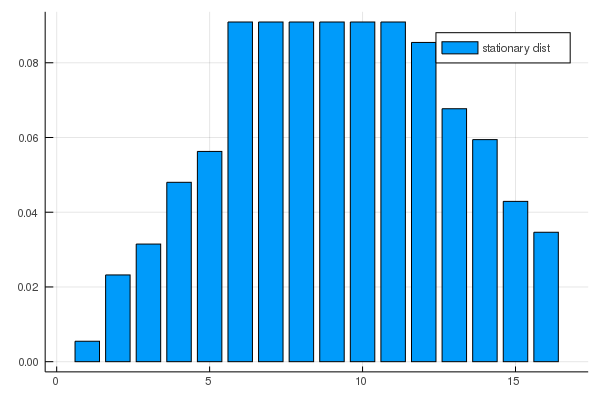

In [15]:
bar(std_2, label = "stationary dist")

Podemos ver a mudança para a direita na massa de probabilidade.

### Formulação do Par do Estado de Ação

O tipo `DiscreteDP` de fato fornece uma segunda interface para configurar uma instância.

Uma das vantagens dessa configuração alternativa é que ela permite o uso de uma matriz esparsa `Q`.

(Um exemplo de uso de matrizes esparsas é dado nos exercícios abaixo)

A chamada assinatura da segunda formulação é `DiscreteDP(R, Q, β, s_indices, a_indices)` onde:

- `s_indices` e `a_indices` são matrizes de comprimento igual a `L` enumerando todos os pares possíveis do estado de ação.
- `R` é uma matriz de comprimento `L` dando recompensas correspondentes.  
- `Q` é uma matriz de probabilidade de transção `L x n`.

Veja como podemos configurar esses objetos para o exemplo anterior.

In [16]:
B = 10
M = 5
α = 0.5
β = 0.9
u(c) = c^α
n = B + M + 1
m = M + 1

s_indices = Int64[]
a_indices = Int64[]
Q = zeros(0, n)
R = zeros(0)

b = 1 / (B + 1)

for s in 0:(M + B)
    for a in 0:min(M, s)
        s_indices = [s_indices; s + 1]
        a_indices = [a_indices; a + 1]
        q = zeros(1, n)
        q[(a + 1):((a + B) + 1)] .= b
        Q = [Q; q]
        R = [R; u(s-a)]
    end
end

ddp = DiscreteDP(R, Q, β, s_indices, a_indices);
results = solve(ddp, PFI)

QuantEcon.DPSolveResult{PFI,Float64}([19.01740221695992, 20.017402216959916, 20.431615779333015, 20.749453024528794, 21.040780991093488, 21.30873018352461, 21.544798161024403, 21.76928181079986, 21.982703576083246, 22.1882432282385, 22.384504796519916, 22.578077363861723, 22.761091269771118, 22.943767083452716, 23.115339958706524, 23.277617618874903], [19.01740221695992, 20.01740221695992, 20.431615779333015, 20.749453024528798, 21.040780991093488, 21.30873018352461, 21.5447981610244, 21.769281810799864, 21.982703576083253, 22.1882432282385, 22.38450479651991, 22.578077363861723, 22.761091269771114, 22.943767083452716, 23.115339958706524, 23.277617618874903], 3, [1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 6, 6, 6], Discrete Markov Chain
stochastic matrix of type Array{Float64,2}:
[0.09090909090909091 0.09090909090909091 … 0.0 0.0; 0.09090909090909091 0.09090909090909091 … 0.0 0.0; … ; 0.0 0.0 … 0.09090909090909091 0.09090909090909091; 0.0 0.0 … 0.09090909090909091 0.09090909090909091])

## Exercícios

Na aula de crescimento ótimo estocástico, [aula de programação dinâmica](https://julia.quantecon.org/optgrowth.html), resolvemos um
[modelo de benchmark](https://julia.quantecon.org/optgrowth.html#benchmark-growth-mod) que possui uma solução analítica para verificar se podemos replicá-lo numericamente.

O exercício é replicar esta solução usando `DiscreteDP`.

## Soluções

Essas foram escritos em conjunto por Max Huber e Daisuke Oyama.

### Configuração

Detalhes do modelo podem ser encontrados na [aula](http://quant-econ.net/jl/optgrowth.html). Como na aula, definimos $ f(k) = k^{\alpha} $ com $ \alpha = 0.65 $,
$ u(c) = \log c $, e $ \beta = 0.95 $.

In [17]:
α = 0.65
f(k) = k.^α
u_log(x) = log(x)
β = 0.95

0.95

Aqui, queremos resolver uma versão de estado finito do modelo de estado contínuo acima. Nós discretizamos o espaço de estados em um *grid* de tamanho
`grid_size = 500`, de $ 10^{-6} $ a `grid_max=2`.

In [18]:
grid_max = 2
grid_size = 500
grid = range(1e-6, grid_max, length = grid_size)

1.0e-6:0.004008014028056112:2.0

Escolhemos a ação como a quantidade de capital a ser poupada no próximo período (o estado é o estoque de capital no início do período). Assim, os índices de estado e os índices de ação são ambos `1`, …,
`grid_size`.  A ação (indexada por) `a` é possível no estado (indexada por) `s` se e somente se `grid[a] < f([grid[s])` (consumo zero não é permitido devido a utilidade em Log)

Então a equação de Bellman é:

$$
v(k) = \max_{0 < k' < f(k)} u(f(k) - k') + \beta v(k'),
$$

onde $ k^{\prime} $ é o capital social no próximo período.

A matriz de probabilidade de transição `Q` será altamente esparsa (na verdade, é degenerada conforme o modelo é determinístico); portanto, formulamos o problema com pares estado-ação, para representar `Q` no formato de matriz esparsa.

Primeiro construímos índices para pares de estado-ação:

In [19]:
C = f.(grid) .- grid'
coord = repeat(collect(1:grid_size), 1, grid_size) #coordenar matriz
s_indices = coord[C .> 0]
a_indices = transpose(coord)[C .> 0]
L = length(a_indices)

118841

Agora vamos configurar $ R $ e $ Q $

In [20]:
R = u_log.(C[C.>0]);

In [21]:
using SparseArrays

Q = spzeros(L, grid_size) # Anteriormente spzeros

for i in 1:L
    Q[i, a_indices[i]] = 1
end

Agora estamos numa posição de criar uma instância de `DiscreteDP`
correspondente ao modelo de crescimento.

In [22]:
ddp = DiscreteDP(R, Q, β, s_indices, a_indices);

### Resolvendo o Modelo

In [23]:
results = solve(ddp, PFI)
v, σ, num_iter = results.v, results.sigma, results.num_iter
num_iter

10

Vamos comparar a solução do modelo discreto com a solução exata do modelo contínuo original. Aqui está a solução exata:

In [24]:
c = f(grid) - grid[σ]

ab = α * β
c1 = (log(1 - α * β) + log(α * β) * α * β / (1 - α * β)) / (1 - β)
c2 = α / (1 - α * β)

v_star(k) = c1 + c2 * log(k)
c_star(k) = (1 - α * β) * k.^α

c_star (generic function with 1 method)

Vamos plotar as funções de valor

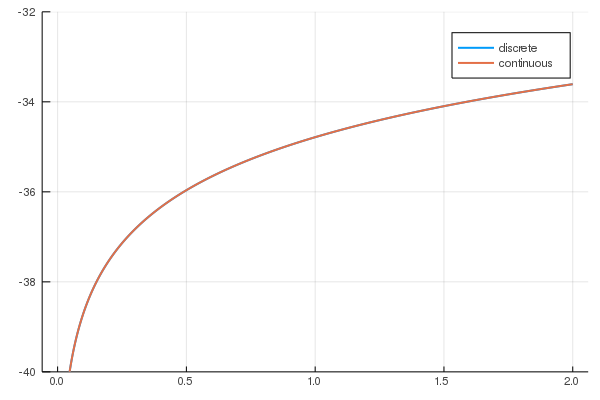

In [25]:
plot(grid, [v v_star.(grid)], ylim = (-40, -32), lw = 2, label = ["discrete" "continuous"])

Eles são dificilmente distinguíveis (embora você possa ver a diferença se aumentar o zoom).

Agora, vejamos as funções políticas discretas e exatas para consumo.

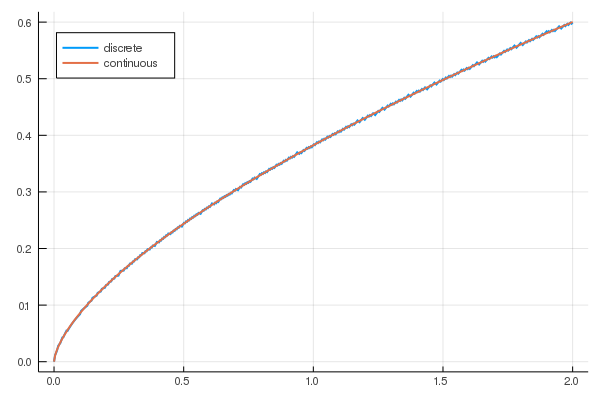

In [26]:
plot(grid, [c c_star.(grid)], lw = 2, label = ["discrete" "continuous"], legend = :topleft)

Essas funções estão novamente próximas, embora alguma diferença seja visível e se torne mais óbvia à medida que você aumenta o zoom. Aqui estão algumas estatísticas:


In [27]:
maximum(abs(x - v_star(y)) for (x, y) in zip(v, grid))

121.49819147053378

Isso é um grande erro, mas a maior parte do erro ocorre no nível mais baixo
dos pontos do grid. Caso contrário, o ajuste é razoável:

In [28]:
maximum(abs(v[idx] - v_star(grid[idx])) for idx in 2:lastindex(v))

0.012681735127500815

A função de valor é monótona, como esperado.

In [29]:
all(x -> x ≥ 0, diff(v))

true

### Comparação dos Métodos de Solução

Vamos tentar diferentes métodos de solução. Os resultados abaixo mostram que a função de iteração de política e a função de iteração de política modificada são muito mais rápidas que a função de iteração de valor.

In [30]:
@benchmark results = solve(ddp, PFI)
results = solve(ddp, PFI);

In [31]:
@benchmark res1 = solve(ddp, VFI, max_iter = 500, epsilon = 1e-4)
res1 = solve(ddp, VFI, max_iter = 500, epsilon = 1e-4);

In [32]:
res1.num_iter

294

In [33]:
σ == res1.sigma

true

In [34]:
@benchmark res2 = solve(ddp, MPFI, max_iter = 500, epsilon = 1e-4)
res2 = solve(ddp, MPFI, max_iter = 500, epsilon = 1e-4);

In [35]:
res2.num_iter

16

In [36]:
σ == res2.sigma

true

### Replicação das figuras

Vamos visualizar a convergência da iteração da função de valor, como na aula.

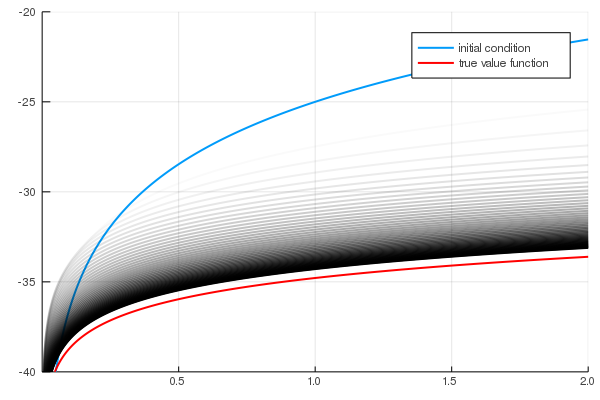

In [37]:
w_init = 5log.(grid) .- 25  # condição inicial
n = 50

ws = []
colors = []
w = w_init
for i in 0:n-1
    w = bellman_operator(ddp, w)
    push!(ws, w)
    push!(colors, RGBA(0, 0, 0, i/n))
end

plot(grid,
     w_init,
     ylims = (-40, -20),
     lw = 2,
     xlims = extrema(grid),
     label = "initial condition")

plot!(grid, ws,  label = "", color = reshape(colors, 1, length(colors)), lw = 2)
plot!(grid, v_star.(grid), label = "true value function", color = :red, lw = 2)

A seguir, plotamos as políticas de consumo ao longo da iteração de valor. Primeiro, escrevemos uma função para gerar e registrar as políticas em determinados estágios da iteração.

In [38]:
function compute_policies(n_vals...)
    c_policies = []
    w = w_init
    for n in 1:maximum(n_vals)
        w = bellman_operator(ddp, w)
        if n in n_vals
            σ = compute_greedy(ddp, w)
            c_policy = f(grid) - grid[σ]
            push!(c_policies, c_policy)
        end
    end
    return c_policies
end

compute_policies (generic function with 1 method)

Agora vamos gerar os plots.

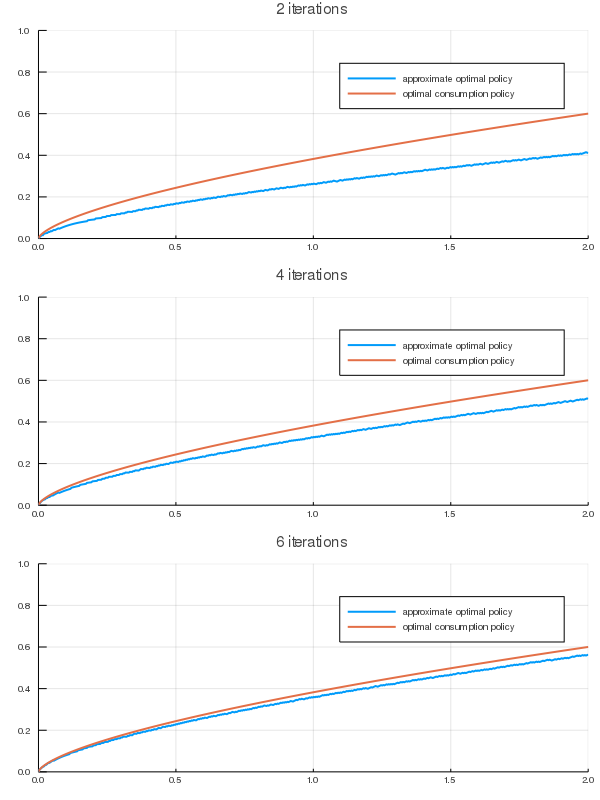

In [39]:
true_c = c_star.(grid)
c_policies = compute_policies(2, 4, 6)
plot_vecs = [c_policies[1] c_policies[2] c_policies[3] true_c true_c true_c]
l1 = "approximate optimal policy"
l2 = "optimal consumption policy"
labels = [l1 l1 l1 l2 l2 l2]
plot(grid,
     plot_vecs,
     xlim = (0, 2),
     ylim = (0, 1),
     layout = (3, 1),
     lw = 2,
     label = labels,
     size = (600, 800),
     title = ["2 iterations" "4 iterations" "6 iterations"])

### Dinâmica do Estoque de Capital

Finalmente, vamos trabalhar no [Exercício
2](https://julia.quantecon.org/dynamic_programming/optgrowth.html#Exercise-1), onde traçamos as trajetórias do estoque de capital para três fatores de desconto diferentes, $ 0.9 $, $ 0.94 $, e $ 0.98 $, com a condição inicial $ k_0 = 0.1 $.

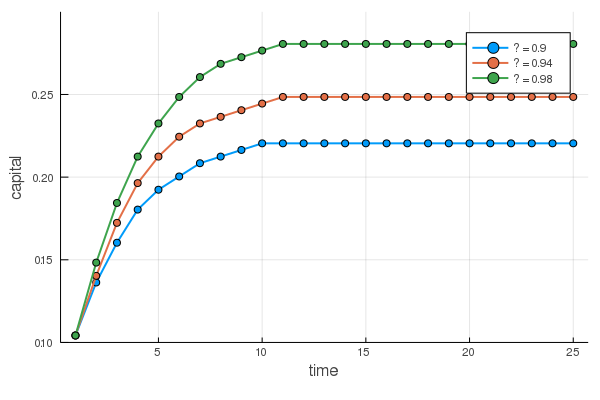

In [40]:
discount_factors = (0.9, 0.94, 0.98)
k_init = 0.1

k_init_ind = findfirst(collect(grid) .≥ k_init)

sample_size = 25

ddp0 = DiscreteDP(R, Q, β, s_indices, a_indices)
k_paths = []
labels = []

for β in discount_factors
    ddp0.beta = β
    res0 = solve(ddp0, PFI)
    k_path_ind = simulate(res0.mc, sample_size, init=k_init_ind)
    k_path = grid[k_path_ind.+1]
    push!(k_paths, k_path)
    push!(labels, "β = $β")
end

plot(k_paths,
     xlabel = "time",
     ylabel = "capital",
     ylim = (0.1, 0.3),
     lw = 2,
     markershape = :circle,
     label = reshape(labels, 1, length(labels)))


<a id='ddp-algorithms'></a>

## Apêndice: Algoritmos

Este apêndice cobre os detalhes dos algoritmos de solução implementados para `DiscreteDP`.

Usaremos as seguintes noções de otimização aproximada:

- Para $ \varepsilon > 0 $, $ v $ é chamada  $ \varepsilon $-aproximação de $ v^* $ se $ \lVert v - v^*\rVert < \varepsilon $  
- Uma política $ \sigma \in \Sigma $ é chamada $ \varepsilon $-ótima se $ v_{\sigma} $ é uma $ \varepsilon $-aproximação de $ v^* $  

### Valor Iteração

O método de valor iteração `DiscreteDP` implementa a função de valor iteração da seguinte maneira:

1. Escolha qualquer $ v^0 \in \mathbb{R}^n $, e especifique $ \varepsilon > 0 $; defina $ i = 0 $.  
1. Compute $ v^{i+1} = T v^i $.  
1. Se $ \lVert v^{i+1} - v^i\rVert <  [(1 - \beta) / (2\beta)] \varepsilon $,
 então vá para o passo 4; caso contrário, defina $ i = i + 1 $ e vá para o passo 2.  
1. Compute uma política $ v^{i+1} $-ganaciosa $ \sigma $, e retorne $ v^{i+1} $ e $ \sigma $.  


Dado $ \varepsilon > 0 $, o algorítimo de valor iteração:

- termina em um número finito de iterações  
- retorna um $ \varepsilon/2 $-aproximação da função de valor ótimo e um $ \varepsilon $-ótimo da função de política ótima (a menos que `iter_max` seja alcançado)  


(Embora não explícito, na implementação real, cada algoritmo é finalizado se o número de iterações atingir `iter_max`)

### Iteração de Política

O método de política de iteração `DiscreteDP` é executado da seguinte maneira:

1. Escolha qualquer $ v^0 \in \mathbb{R}^n $ e compute uma política $ v^0 $-gananciosa $ \sigma^0 $; defina $ i = 0 $.  
1. Compute o valor $ v_{\sigma^i} $ resolvendo
  a equação $ v = T_{\sigma^i} v $.  
1. Compute uma política $ v_{\sigma^i} $-gananciosa
  $ \sigma^{i+1} $; Faça $ \sigma^{i+1} = \sigma^i $ se possível
1. Se $ \sigma^{i+1} = \sigma^i $, então retorne $ v_{\sigma^i} $
  e $ \sigma^{i+1} $; caso contrário, defina $ i = i + 1 $ e vá para o passo 2.  


O algoritmo de iteração de política termina em um número finito de iterações.

Ele retorna uma função de valor ideal e uma função de política ideal (a menos que `iter_max` seja atingido).

### Iteração de Política Modificada
O método de iteração de política modificada `DiscreteDP` é executado da seguinte maneira:

1. Escolha qualquer $ v^0 \in \mathbb{R}^n $, e especifique $ \varepsilon > 0 $ e $ k \geq 0 $; defina $ i = 0 $.  
1. Compute uma política $ v^i $-gananciosa $ \sigma^{i+1} $; Faça $ \sigma^{i+1} = \sigma^i $ se possível (para $ i \geq 1 $).  
1. Compute $ u = T v^i $ ($ = T_{\sigma^{i+1}} v^i $). Se $ \mathrm{span}(u - v^i) < [(1 - \beta) / \beta] \varepsilon $, então vá para o passo 5; caso contrário vá para o passo 4.  
  - O período é definido por $ \mathrm{período}(z) = \max(z) - \min(z) $  
1. Compute $ v^{i+1} = (T_{\sigma^{i+1}})^k u $ ($ = (T_{\sigma^{i+1}})^{k+1} v^i $); defina $ i = i + 1 $ e vá para o passo 2.  
1. Retorne $ v = u + [\beta / (1 - \beta)] [(\min(u - v^i) + \max(u - v^i)) / 2] \mathbf{1} $ e $ \sigma_{i+1} $.  


Dado $ \varepsilon > 0 $, desde que $ v^0 $ é tal que
$ T v^0 \geq v^0 $, o algoritmo de iteração de política modificado termina em um número finito de iterações.

Ele retorna uma $ \varepsilon/2 $-aproximação da função de valor ótimo e uma $ \varepsilon $-função de política ótima (a menos que `iter_max` seja atingido)

Veja também a documetação para `DiscreteDP`.